In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Dataset, data analysis and manipulation


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

###EPITOME 'emotional reactions'

In [ ]:
#The dataset used for the first finetuning step in this notebook was authored by Sharma et al. Full citation below.
_CITATION = """\
@inproceedings{sharma2020empathy,
    title={A Computational Approach to Understanding Empathy Expressed in Text-Based Mental Health Support},
    author={Sharma, Ashish and Miner, Adam S and Atkins, David C and Althoff, Tim},
    year={2020},
    booktitle={EMNLP}}
"""

In [ ]:
#First, we want to finetune the model on the EPITOME dataset (Sharma et al., 2020). This dataset contains
#mental-health-related response posts from Reddit scored from 0 to 2 for three different types of empathy.
#Here we only use the 'emotional reactions' type, as it is the only type that does not rely heavily on 
#the context, and the most similar to the responses in our own dataset

data = pd.read_csv('drive/MyDrive/emotional-reactions-reddit.csv') #put data in Drive root folder or change path

In [ ]:
#We will not make use of other context (e.g. seeker_post) to classify the response posts, since we do not
#have that kind of context in our dataset. So we can drop the unnecessary columns 
data.drop(['sp_id', 'rp_id', 'seeker_post', 'rationales'], axis=1, inplace=True)

#and replace integers values with more meaningful string-type labels
data = data.replace({0: 'no', 1: 'weak', 2: 'strong'})

#empathy labels
label2int = {
  "no": 0,
  "weak": 1,
  "strong": 2
}

In [ ]:
#This dataset has 3084 samples
len(data)

3084

In [ ]:
#but the labels are far from balanced. The large majority of response_posts has no empathy
data.groupby('level').count()

,response_post
level,
no,2037
strong,152
weak,895


In [ ]:
#We rebalance the classes. first we downsample the 'no' class and upsample the others
df_majority  = data[data.level=='no']
df_minority1 = data[data.level=='strong']
df_minority2 = data[data.level=='weak']

#downsample majority class and upsample minority classes
df_majority = df_majority.sample(int(len(data)/3), random_state=0)
df_minority1 = df_minority1.sample(int(len(data)/3), random_state=0, replace=True)
df_minority2 = df_minority2.sample(int(len(data)/3), random_state=0, replace=True)

#concat the majority and minority dataframes
df_new = pd.concat([df_majority, df_minority1, df_minority2])

#shuffle the dataset
data = df_new.sample(frac=1, random_state=0).reset_index(drop=True)

In [ ]:
#We generate the text files for your train, val, and test datasets. We use the same split
#as Sharma et al. to better compare results. That is 75:5:20 for train, val, test.

from sklearn.model_selection import train_test_split

#Uncomment line below to create directory in Drive to run the rest of the code
#!mkdir 'drive/MyDrive/empathy_classifier_data'

train_path = "drive/MyDrive/empathy_classifier_data/train.txt"
test_path = "drive/MyDrive/empathy_classifier_data/test.txt"
val_path = "drive/MyDrive/empathy_classifier_data/val.txt"

#Creating training and validation sets using an 75-25 split
input_train, input_val, target_train, target_val = train_test_split(data.response_post.to_numpy(), 
                                                                    data.level.to_numpy(), 
                                                                    test_size=0.25)

#Split the validataion further to obtain a holdout dataset - split 20:80
input_val, input_test, target_val, target_test = train_test_split(input_val, target_val, test_size=0.8)

#Create a dataframe for each dataset
train_dataset = pd.DataFrame(data={"text": input_train, "class": target_train})
val_dataset = pd.DataFrame(data={"text": input_val, "class": target_val})
test_dataset = pd.DataFrame(data={"text": input_test, "class": target_test})
final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }

#Write dataframes to file
train_dataset.to_csv(train_path, sep=";",header=False, index=False)
val_dataset.to_csv(val_path, sep=";",header=False, index=False)
test_dataset.to_csv(test_path, sep=";",header=False, index=False)

#Finetune a pretrained T5 transformer for the empathy classification task

In [ ]:
%%capture
!pip install transformers==2.9.0 
!pip install pytorch_lightning==0.7.5
!pip install sentencepiece

In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

import gc

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [ ]:
args_dict = dict(
    data_dir="", #path for data files
    output_dir="", #path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=1e-3,
    weight_decay=0.0,
    adam_epsilon=1e-3, 
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=6,
    gradient_accumulation_steps=2,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, 
    opt_level='O1', 
    max_grad_norm=1.0, 
    seed=42,
)

In [ ]:
#Load the tokenizer for the T5-base model
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:filelock:Lock 139676564243472 acquired on /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpe3r3801j


Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model in cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:filelock:Lock 139676564243472 released on /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f.lock
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f

In [ ]:
#Try out the tokenizer
text = "How are you feeling today?"
enc = tokenizer.encode_plus(text)
print(enc)

{'input_ids': [571, 33, 25, 1829, 469, 58], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}


In [ ]:
#See how the labels are encoded
labels = ["no", "weak", "strong"]
for lab in labels:
  print(tokenizer.encode(lab))

[150]
[5676]
[1101]


In [ ]:
class EmpathyDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.path = os.path.join(data_dir, type_path + '.txt')

    self.data_column = "text"
    self.class_column = "score"
    self.data = pd.read_csv(self.path, sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    for idx in range(len(self.data)):
      input_, target = self.data.loc[idx, self.data_column], self.data.loc[idx, self.class_column]      
      
      input_ = input_ + ' </s>'
      target = str(target) + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [ ]:
#Sanity check that the size is what we expect
dataset = EmpathyDataset(tokenizer, 'drive/MyDrive/empathy_classifier_data/', 'test', 512)
len(dataset)

617

In [ ]:
#Check one sample
data = dataset[42]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

That's hard. Especially if you're the type of person to post in this sub. Loving yourself is really difficult. But loving others is easier. And I do love you. When you love others, I find, its easier to love yourself. Even just saying the words and seeing it echoed back makes me feel good. I hope I helped.
strong


##Train

In [ ]:
#Uncomment line below to create folder in Drive
#!mkdir -p 'drive/MyDrive/t5_empathy'

In [ ]:
args_dict.update({'data_dir': 'drive/MyDrive/empathy_classifier_data/', 'output_dir': 'drive/MyDrive/t5_empathy', 'num_train_epochs':6})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': 'drive/MyDrive/empathy_classifier_data/', 'output_dir': 'drive/MyDrive/t5_empathy', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_seq_length': 512, 'learning_rate': 0.001, 'weight_decay': 0.0, 'adam_epsilon': 0.001, 'warmup_steps': 0, 'train_batch_size': 1, 'eval_batch_size': 1, 'num_train_epochs': 6, 'gradient_accumulation_steps': 16, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

In [ ]:
def get_dataset(tokenizer, type_path, args):
  return EmpathyDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [ ]:
#clear cache before starting
torch.cuda.empty_cache()

In [ ]:
#create new instance of T5 finetuner
model = T5FineTuner(args)

In [ ]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [ ]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#train model
trainer.fit(model)

In [ ]:
#save model (uncomment to save)
'''
torch.save(model.state_dict(), 'drive/MyDrive/t5_empathy/T5empathy_finetuned.pt')
'''

In [ ]:
device = torch.device('cuda:0')

In [ ]:
#load model (uncomment to load)
'''
model = T5FineTuner(args)
model.load_state_dict(torch.load('drive/MyDrive/t5_empathy/T5empathy_finetuned.pt'))
model.to(device)
'''

##Evaluate on the test set

In [ ]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [ ]:
dataset = EmpathyDataset(tokenizer, 'drive/MyDrive/empathy_classifier_data', 'test', 512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
it = iter(loader)

In [ ]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [ ]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [ ]:
#print out some samples with prediction and target
for i in range(32):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual label: %s" % targets[i])
    print("predicted label: %s" % dec[i])
    print("=====================================================================\n")

text: I'm sorry. You have no one to talk to?

Actual label: strong
predicted label: strong

text: I feel you. Have you thought about speaking to a therapist or call a depression hotline? I'm
not sure where you are living, but those calls are usually free and the people on the other end are
pretty great at listening and coming up with helpful strategies. Hang in there.

Actual label: weak
predicted label: weak

text: Don't worry, we are mortal for a reason.

Actual label: weak
predicted label: weak

text: Chill man high school isn't that bad all you have to do is just be chill and if you don't want
to talk to anyone that's fine but eventually someone will want to talk to you that's just how it is
:)

Actual label: strong
predicted label: strong

text: Can you talk about whats going on in your head? Maybe if you get it out, it will be a little
more sorted? I'm sorry it's so overwhelming right now. Someone loves you, they just don't know how
to show it the right way, right now.

Actual la

###Test metrics

In [ ]:
#Run full test set evaluation
dataset = EmpathyDataset(tokenizer, 'drive/MyDrive/empathy_classifier_data', 'test', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
for i, out in enumerate(outputs):
  if out not in labels:
    print(i, 'detected invalid prediction')
    #added to deal with invalid predictions arising from txt file:
    del outputs[i]
    del targets[i]

In [ ]:
print(metrics.classification_report(targets, outputs, digits=4))

              precision    recall  f1-score   support

          no     0.9323    0.7617    0.8384       235
      strong     0.9700    1.0000    0.9848       194
        weak     0.7600    0.9096    0.8281       188

    accuracy                         0.8817       617
   macro avg     0.8874    0.8904    0.8838       617
weighted avg     0.8917    0.8817    0.8813       617



###Confusion matrix

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
cm = metrics.confusion_matrix(targets, outputs)

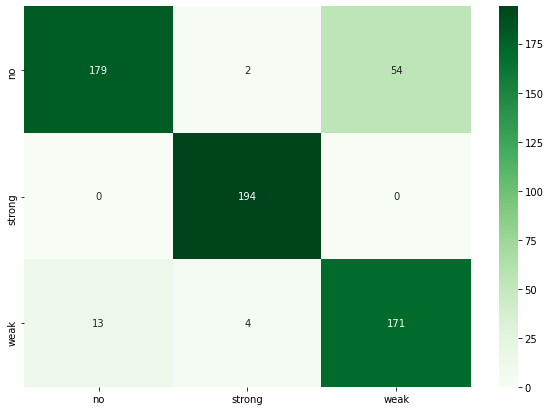

In [ ]:
df_cm = pd.DataFrame(cm, index = ["no", "strong", "weak"], columns = ["no", "strong", "weak"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g')

#Further finetune the model on the 1100 labelled samples from our dataset

In [ ]:
#retrieve paths of splits as defined in the baseline notebook

train_path = "drive/MyDrive/empathy_classifier_data/my_train.txt"
test_path = "drive/MyDrive/empathy_classifier_data/my_test.txt"
val_path = "drive/MyDrive/empathy_classifier_data/my_val.txt"

In [ ]:
#redefine model class with correct paths
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="my_train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="my_val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

##Train the T5 model

In [ ]:
#load the tokenizer for this model
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


In [ ]:
dataset = EmpathyDataset(tokenizer, 'drive/MyDrive/empathy_classifier_data/', 'my_val', 512)

In [ ]:
#show a sample
data = dataset[31]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

Did something in particular happen that led to this?
no


In [ ]:
#clear cache before starting
torch.cuda.empty_cache()

In [ ]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=1e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=1,
    eval_batch_size=1,
    num_train_epochs=12,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, 
    opt_level='O1', 
    max_grad_norm=1.0,
    seed=42,
)

In [ ]:
args_dict.update({'data_dir': 'drive/MyDrive/empathy_classifier_data/', 'output_dir': 'drive/MyDrive/t5_empathy', 'num_train_epochs':12})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': 'drive/MyDrive/empathy_classifier_data/', 'output_dir': 'drive/MyDrive/t5_empathy', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_seq_length': 512, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 1, 'eval_batch_size': 1, 'num_train_epochs': 12, 'gradient_accumulation_steps': 16, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Checkpoint directory drive/MyDrive/t5_empathy exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


In [ ]:
def get_dataset(tokenizer, type_path, args):
  return EmpathyDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [ ]:
#load the weights of the model previously finetuned on the emotional reactions dataset
device = torch.device('cuda:0')
model = T5FineTuner(args)
model.load_state_dict(torch.load('drive/MyDrive/t5_empathy/T5empathy_finetuned.pt'))
model.to(device)

In [ ]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [ ]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#train loop
trainer.fit(model)

In [ ]:
#save model (uncomment to save)
'''
torch.save(model.state_dict(), 'drive/MyDrive/t5_empathy/T5_empathy_twicefinetuned.pt')
'''

In [ ]:
device = torch.device('cuda:0')

In [ ]:
#load model (uncomment to load)
'''
model = T5FineTuner(args)
model.load_state_dict(torch.load('drive/MyDrive/t5_empathy/T5_empathy_twicefinetuned.pt'))
model.to(device)
'''

##Test set evaluation

In [ ]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [ ]:
dataset = EmpathyDataset(tokenizer, 'drive/MyDrive/empathy_classifier_data', 'my_test', 512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
it = iter(loader)

In [ ]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [ ]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [ ]:
#print some predictions
for i in range(32):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual label: %s" % targets[i])
    print("predicted label: %s" % dec[i])
    print("=====================================================================\n")

text: Is there anything going on in your personal life that could be upsetting, have you fallen out
with anyone close to you?

Actual label: weak
predicted label: weak

text: I have some recommendations for you. Please take a look and choose any protocol that you'd
like to try.

Actual label: no
predicted label: weak

text: Are you in the middle of some trauma of a personal nature, like difficulties with family
members or friends?

Actual label: weak
predicted label: no

text: In all honesty, do you think that you are always available to consider alternatives to your
point of view?

Actual label: weak
predicted label: weak

text: When things go wrong, do you always think that you are to blame?

Actual label: no
predicted label: no

text: Did you try to complete Protocol 6 and it resulted in reawakening some bad feelings due to
things that happened in the past?

Actual label: weak
predicted label: weak

text: Ah, I see. Is this something that's happened recently or a while ago?

Actual 

In [ ]:
dataset = EmpathyDataset(tokenizer, 'drive/MyDrive/empathy_classifier_data/', 'my_test', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
for i, out in enumerate(outputs):
  if out not in labels:
    print(i, 'detected invalid prediction')
    del outputs[i]
    del targets[i]

In [ ]:
#metrics
print(metrics.classification_report(targets, outputs, digits=4))

              precision    recall  f1-score   support

          no     0.8919    0.8250    0.8571        40
      strong     0.7436    0.8286    0.7838        35
        weak     0.6286    0.6111    0.6197        36

    accuracy                         0.7568       111
   macro avg     0.7547    0.7549    0.7535       111
weighted avg     0.7597    0.7568    0.7570       111



####Confusion matrix

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
cm = metrics.confusion_matrix(targets, outputs)

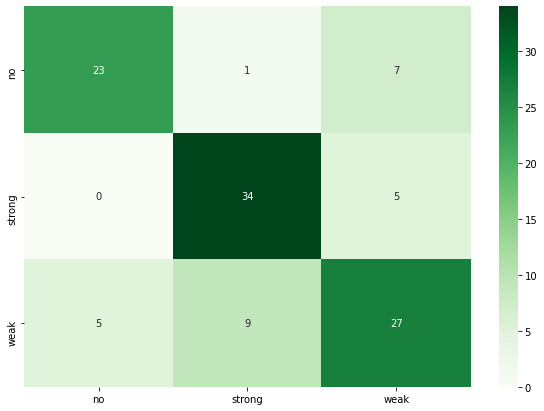

In [ ]:
df_cm = pd.DataFrame(cm, index = ["no", "strong", "weak"], columns = ["no", "strong", "weak"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g')

#Generate single empathy score prediction for a given string

In [ ]:
#define get_empathy_score function to generate individual prediction

def empathy_score(text):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt').cuda()

  output = model.model.generate(input_ids=input_ids, max_length=2).cuda()

  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]

  if label == 'no':
    score = 0
  elif label == 'weak':
    score = 1
  else:
    score = 2
    
  return score

In [ ]:
text="Thank you. Do you feel like you can listen to others to help you get through things?" #change here as necessary
empathy_score(text)

1